# Fine amplitude calibration

The amplitude of a pulse can be precisely calibrated using error amplifying gate sequences. These gates sequences apply a variable number of times the same gate. Therefore, if each gate has a small error $\delta\theta$ in the rotation angle then a sequence of $n$ gates will have a rotation error of $n\cdot\delta\theta$. We will work with *ibmq_armonk* and compare our results to those reported by the backend.

In [1]:
import numpy as np

from qiskit_experiments.library import FineXAmplitude, FineSXAmplitude
import qiskit.pulse as pulse

from qiskit import IBMQ

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [3]:
qubit = 0

In [4]:
x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit,)).instructions[0][1].pulse
x_pulse

Drag(duration=320, amp=(0.806572374879525+0j), sigma=80, beta=-0.7010511722691619, name='Xp_d0')

In [5]:
ideal_amp = x_pulse.amp
print(f"The reported amplitude of the X pulse is {ideal_amp:.4f}.")

The reported amplitude of the X pulse is 0.8066+0.0000j.


### Detect an over-rotated pulse

We now take the x pulse reported by the backend and add a 10% overrotation to it by scaling the amplitude and see if the experiment can detect this overrotation.

In [6]:
pulse_amp = ideal_amp*1.01
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_over:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [7]:
amp_cal = FineXAmplitude(qubit)
amp_cal.set_experiment_options(schedule=xp_over)

Observe here that we added a square-root of X pulse before appyling the error amplifying sequence. This is done to be able to distinguish between over-rotated and under-rotated pulses.

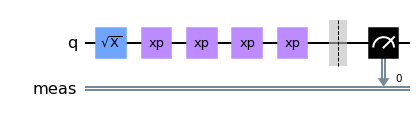

In [8]:
amp_cal.circuits(backend)[5].draw(output="mpl")

In [9]:
data_over = amp_cal.run(backend).block_for_results()

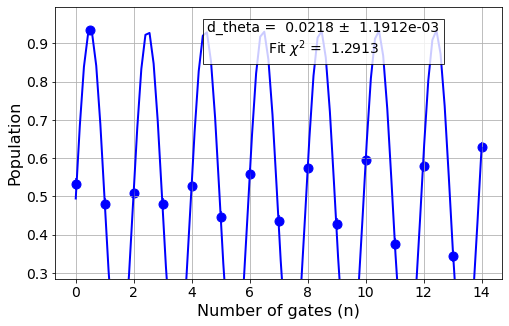

In [10]:
data_over.figure(0)

In [11]:
print(data_over.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: 0.021765160440762838 ± 0.001191211947896467
- χ²: 1.2912616980842198
- quality: good
- device_components: ['Q0']
- verified: False


In [12]:
dtheta = data_over.analysis_results("d_theta").value.value
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.022 rad.
Thus, scale the 0.8146+0.0000j pulse amplitude by 0.993 to obtain 0.80903+0.00000j.
Amplitude reported by the backend 0.8066+0.0000j.


### Detect an under-rotated pulse

In [13]:
pulse_amp = ideal_amp*0.99
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_under:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [14]:
amp_cal = FineXAmplitude(qubit)
amp_cal.set_experiment_options(schedule=xp_under)

In [15]:
data_under = amp_cal.run(backend).block_for_results()

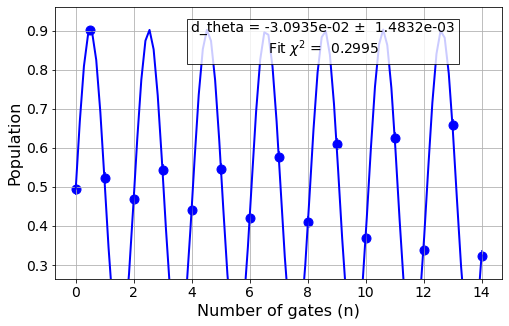

In [16]:
data_under.figure(0)

In [17]:
print(data_under.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: -0.03093528161507679 ± 0.0014832269864158724
- χ²: 0.2995119390258925
- quality: good
- device_components: ['Q0']
- verified: False


In [18]:
dtheta = data_under.analysis_results("d_theta").value.value
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of -0.031 rad.
Thus, scale the 0.7985+0.0000j pulse amplitude by 1.010 to obtain 0.80645+0.00000j.
Amplitude reported by the backend 0.8066+0.0000j.


### Analyze a pi-half pulse

We now consider the pi-half rotation. Note that in this case we do not need to add a pi-half rotation to the circuits.

In [19]:
pulse_amp = ideal_amp / 2
target_angle = np.pi / 2

with pulse.build(backend=backend, name="x90p") as x90p:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [20]:
amp_cal = FineSXAmplitude(qubit)
amp_cal.set_experiment_options(schedule=x90p)

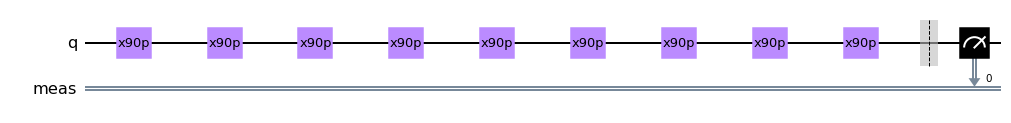

In [21]:
amp_cal.circuits(backend)[5].draw(output="mpl")

In [22]:
data_x90p = amp_cal.run(backend).block_for_results()

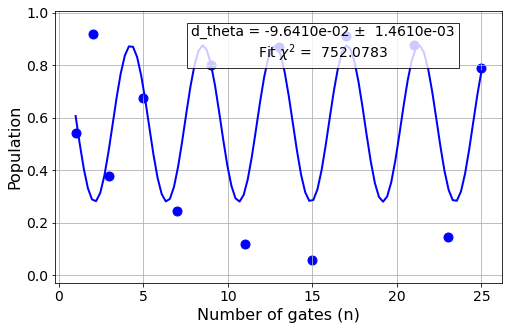

In [23]:
data_x90p.figure(0)

In [24]:
print(data_x90p.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: -0.09640971201964088 ± 0.0014609768942987333
- χ²: 752.0783386102254
- quality: bad
- device_components: ['Q0']
- verified: False


In [25]:
sx = backend.defaults().instruction_schedule_map.get('sx', (qubit,))
sx_ideal_amp = sx.instructions[0][1].pulse.amp

dtheta = data_x90p.analysis_results("d_theta").value.value
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of -0.096 rad.
Thus, scale the 0.4033+0.0000j pulse amplitude by 1.065 to obtain 0.42966+0.00000j.
Amplitude reported by the backend 0.3710-0.0773j.


Let's rerun this calibration using the updated value of the amplitude of the pi-half pulse.

In [26]:
pulse_amp = ideal_amp / 2 * scale
target_angle = np.pi / 2

with pulse.build(backend=backend, name="x90p") as x90p:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [27]:
amp_cal.set_experiment_options(schedule=x90p)

In [28]:
data_x90p = amp_cal.run(backend).block_for_results()

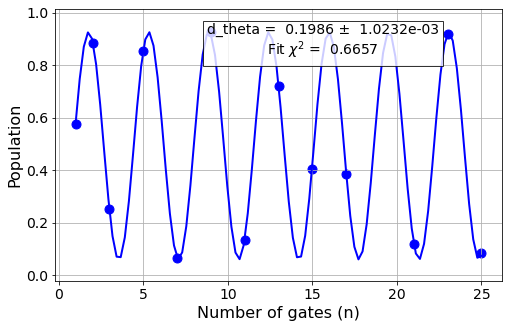

In [29]:
data_x90p.figure(0)

In [30]:
print(data_x90p.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: 0.1986155323889153 ± 0.0010232398309370301
- χ²: 0.6656887665375697
- quality: good
- device_components: ['Q0']
- verified: False


In [31]:
dtheta = data_x90p.analysis_results("d_theta").value.value
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of 0.199 rad.
Thus, scale the 0.4297+0.0000j pulse amplitude by 0.888 to obtain 0.38143+0.00000j.
Amplitude reported by the backend 0.3710-0.0773j.


In [32]:
import qiskit.tools.jupyter
%qiskit_copyright